Nama Lengkap: Muhammad Sulthan Nasyira

Alur Belajar: Machine Learning Engineer

Cohort ID: MC589D5Y2486

Coding Camp Email Username: mc589d5y2486@student.devacademy.id

Email Terdaftar: sulthanasyirah@gmail.com

Group Belajar: MC-49

predictive analysis crypto bitcoin (time series)

Tujuan dari proyek ini adalah membangun model prediksi harga Bitcoin berbasis Machine Learning yang dapat memperkirakan harga untuk hari berikutnya. Model ini diharapkan bisa menangkap pola dari data historis dan memberikan hasil yang lebih akurat dibandingkan dengan metode konvensional. Model ini tidak bertujuan untuk menjadi satu-satunya acuan dalam pengambilan keputusan, tetapi sebagai alat bantu tambahan yang bisa memberikan pandangan berbasis data, terutama bagi mereka yang ingin mengurangi risiko dalam aktivitas jual beli aset kripto.

data yang digunakan berasal dari sumber berikut: https://www.kaggle.com/datasets/novandraanugrah/bitcoin-historical-datasets-2018-2024?select=btc_1h_data_2018_to_2025.csv


# 1. Import Library

Pertama, kita akan mengimpor seluruh library yang dibutuhkan dalam proyek ini. Library mencakup manipulasi data, visualisasi, preprocessing, serta membangun dan mengevaluasi model LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 2. Load Data

Langkah ini bertujuan untuk memuat dataset dan melakukan eksplorasi awal terhadap struktur data, informasi kolom, nilai yang hilang, dan statistik deskriptif

In [ ]:
import pandas as pd
from tabulate import tabulate

# Load dataset
df = pd.read_csv('bitcoin_2018_2025.csv')

# Preprocessing sesuai perintah user
df['Open time'] = pd.to_datetime(df['Open time'])
df = df.rename(columns={'Open time': 'Date'})
df.set_index('Date', inplace=True)
df = df.sort_index()

# Informasi dataset
print("\nInformasi Dataset:")
print(df.info())

# Cek jumlah missing values
missing_values = df.isnull().sum()
print("\nMissing Values per Kolom:")
print(tabulate(missing_values.reset_index().rename(columns={0: 'Missing Values', 'index': 'Kolom'}), headers='keys', tablefmt='fancy_grid'))

# Cek jumlah duplikasi
duplicate_count = df.duplicated().sum()
print(f"\nJumlah Duplikasi: {duplicate_count}")

# Statistik deskriptif
df_describe = df.describe()
print("\nStatistik Deskriptif:")
print(tabulate(df_describe, headers='keys', tablefmt='fancy_grid', showindex=True))



Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64439 entries, 2018-01-01 00:00:00 to 2025-05-14 00:00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open                          64439 non-null  float64
 1   High                          64439 non-null  float64
 2   Low                           64439 non-null  float64
 3   Close                         64439 non-null  float64
 4   Volume                        64439 non-null  float64
 5   Close time                    64439 non-null  object 
 6   Quote asset volume            64439 non-null  float64
 7   Number of trades              64439 non-null  int64  
 8   Taker buy base asset volume   64439 non-null  float64
 9   Taker buy quote asset volume  64439 non-null  float64
 10  Ignore                        64439 non-null  int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 5.9+ MB
None

M

# 3. Ambil data

Kita hanya akan menggunakan data harga selama 5 tahun terakhir untuk membangun model prediksi

In [ ]:
last_date = df.index[-1]
start_date = last_date - pd.DateOffset(years=5)
df = df[df.index >= start_date]

# 4. Visualisasi Data Historis

Visualisasi harga penutupan Bitcoin selama 5 tahun terakhir untuk melihat tren umum dan pola harga

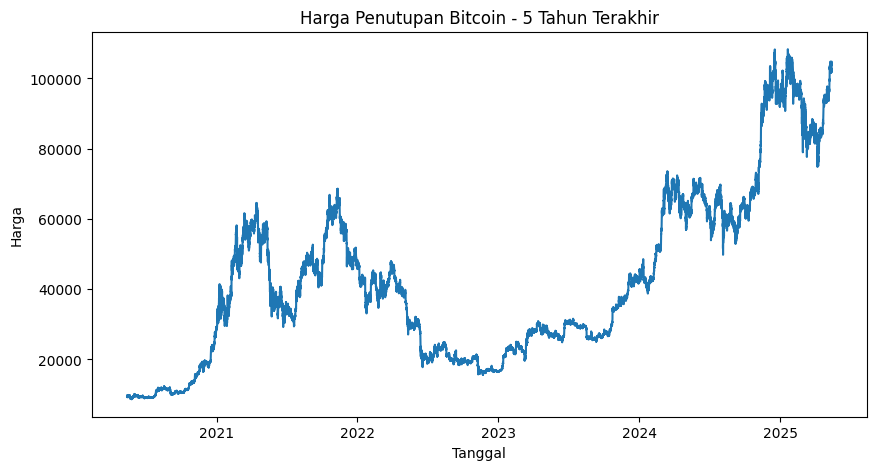

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'])
plt.title('Harga Penutupan Bitcoin - 5 Tahun Terakhir')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.show()

# 5. Normalisasi

Data dinormalisasi menggunakan `MinMaxScaler` agar lebih sesuai untuk model LSTM yang sensitif terhadap skala data

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# 6. Membuat Dataset untuk LSTM

Data diubah menjadi format urutan dengan jendela waktu (window size) agar sesuai untuk input model LSTM

In [ ]:
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 1800
X, y = create_dataset(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 7. Split Data

Membagi data menjadi training (80%) dan testing (20%) untuk evaluasi model

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 8. Membangun dan Melatih Model

Model LSTM dibangun menggunakan dua layer LSTM dan satu layer Dense output. Model dilatih untuk meminimalkan `mean_squared_error`

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

print("Training model...")
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model...
Epoch 1/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 105s 92ms/step - loss: 0.0021
Epoch 2/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 137s 90ms/step - loss: 4.2327e-05
Epoch 3/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - loss: 3.4504e-05
Epoch 4/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - loss: 2.8008e-05
Epoch 5/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - loss: 2.1920e-05
Epoch 6/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - loss: 1.7309e-05
Epoch 7/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - loss: 1.5536e-05
Epoch 8/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - loss: 1.5861e-05
Epoch 9/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - loss: 1.1888e-05
Epoch 10/10
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - loss: 1.4029e-05


263/263 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step


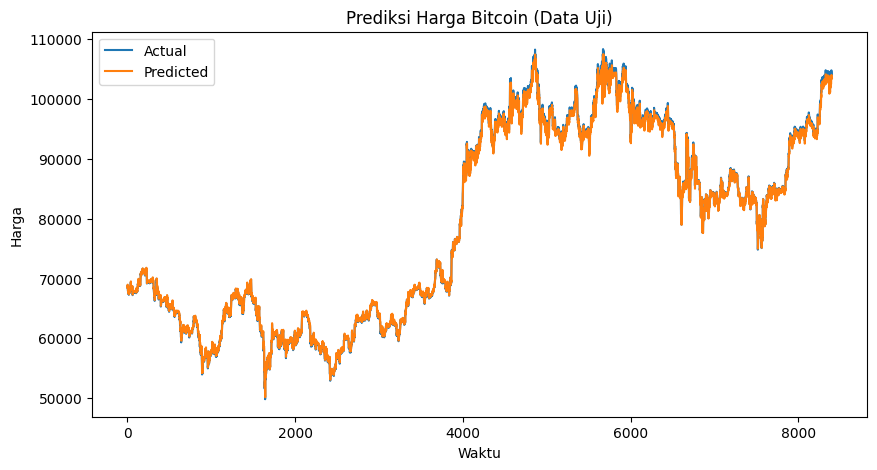

MSE : 300644.00
MAE : 388.28
R² Score : 0.9988


In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Prediksi Harga Bitcoin (Data Uji)')
plt.xlabel('Waktu')
plt.ylabel('Harga')
plt.legend()
plt.show()

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'MSE : {mse:.2f}')
print(f'MAE : {mae:.2f}')
print(f'R² Score : {r2:.4f}')

# 9. Prediksi

Melakukan prediksi pada data test, lalu membandingkan hasilnya dengan data aktual. Hasil divisualisasikan dan diukur dengan metrik MSE, MAE, dan R²

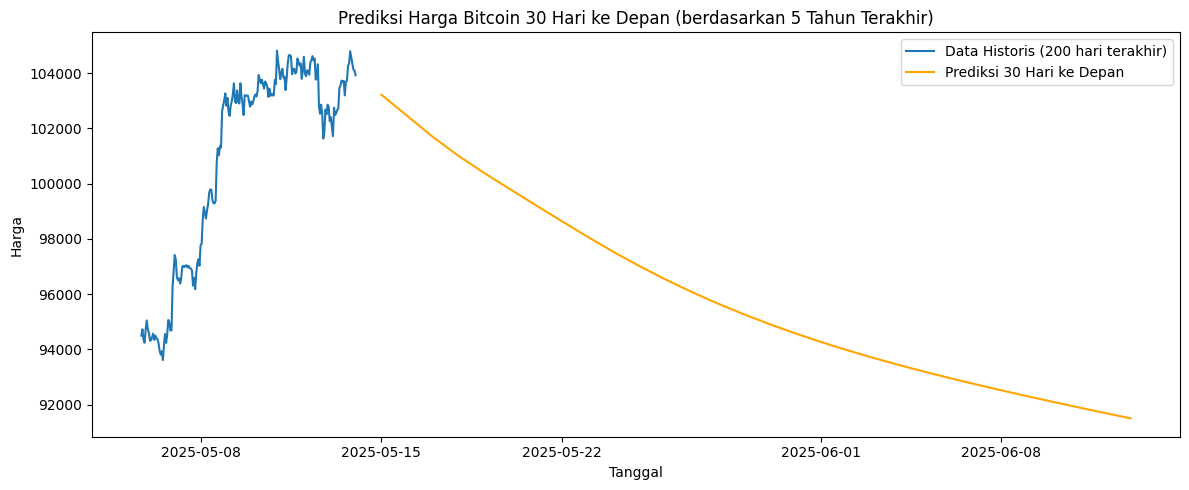

In [ ]:
last_60_days = scaled_data[-window_size:]
input_seq = last_60_days.reshape(1, window_size, 1)

future_predictions = []
for _ in range(30):
    next_pred = model.predict(input_seq, verbose=0)[0, 0]
    future_predictions.append(next_pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[next_pred]]], axis=1)

future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12, 5))
plt.plot(df.index[-200:], df['Close'].values[-200:], label='Data Historis (200 hari terakhir)')
plt.plot(future_dates, future_predictions_inv, label='Prediksi 30 Hari ke Depan', color='orange')
plt.title('Prediksi Harga Bitcoin 30 Hari ke Depan (berdasarkan 5 Tahun Terakhir)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.tight_layout()
plt.show()